Import MDAnalysis Module (https://www.mdanalysis.org/) and Matplotlib <br/> 
Don't forget to add the permissions: <br/>
sudo jupyter-nbextension enable nglview --py --sys-prefix <br/>
sudo  jupyter-nbextension enable --py widgetsnbextension <br/>

In [152]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv

import warnings
warnings.filterwarnings('ignore')

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# no GM1

name = '_DPPC_DIPC_chol_352'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/'
fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# 5% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT - no GM1

name = '_DPPC_DIPC_chol_352'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

In [153]:
# name and files for the simulation studied LPT - 5% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/5_GM1/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

Load xtc and gro files using mda.Universe('struct file','traj file')

In [154]:
u = mda.Universe( path+fgro, path+fxtc)

In [155]:
sel_all = u.select_atoms("all and (name PO4 or name GM5)")

In [157]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all)
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

In [158]:
# TAKE THE LAST FRAME

u.trajectory[9999]

< Timestep 9999 with unit cell dimensions [431.38272 431.38272 197.55995  90.       90.       90.     ] >

In [159]:
# set the x and y min and max values

sel_all = "all and (name PO4 or name GM1)"
patch = u.select_atoms(sel_all).positions
print(patch)

xmax = max(patch[:,0])
ymax = max(patch[:,1])
#dmax = int(min(xmax,ymax))
print(xmax)
print(ymax)

xmin = min(patch[:,0])
ymin = min(patch[:,1])

print(xmin)
print(ymin)

[[ 26.070002 393.04      73.04    ]
 [ 23.79     278.43      94.23    ]
 [ 44.32     197.87001   87.1     ]
 ...
 [132.79001  216.87      56.43    ]
 [258.23     323.2       32.4     ]
 [176.84     264.72003   54.480003]]
431.35004
431.34003
0.13
0.080000006


In [160]:
# select the atoms in the membrane and divide the bilayer into 2 leaflets selecting the species you want

sel_tot = "all and (name PO4 or name GM1)"


u.trajectory[2]
Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4 or name GM1')
leaflet0 = Lf.groups(0)
leaflet1 = Lf.groups(1)

l0 = leaflet0.select_atoms(sel_tot).positions
l1 = leaflet1.select_atoms(sel_tot).positions
m_tot = u.select_atoms(sel_tot).positions

print('total number of lipids: %d' % len(m_tot))
print('number of lipids in the upper leaflet: %d + number of lipids in the lower leaflet:%d \n= %d' % (len(l0),len(l1),len(l0)+len(l1)))

if (len(m_tot) != len(l0)+len(l1) ):
    print('PROBLEM!')

total number of lipids: 5254
number of lipids in the upper leaflet: 2658 + number of lipids in the lower leaflet:2596 
= 5254


In [161]:
# set the number of boxes into which will be divided the membrane

N = 15
dx = (xmax-xmin)/N
dy = (ymax-ymin)/N
print(dx)
print(dy)

28.748002115885416
28.750669352213542


In [162]:
# TAKE THE LAST FRAME

u.trajectory[9999]

< Timestep 9999 with unit cell dimensions [431.38272 431.38272 197.55995  90.       90.       90.     ] >

(225, 3)


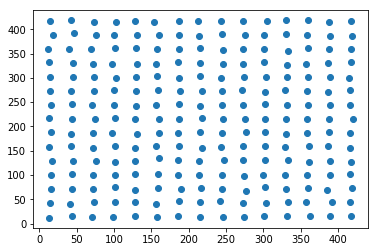

In [163]:
# leaflet 0
# divide the leaflet into a grid and calculate the concentration ratio in each box

bary0 = []
#del Mphi0

Mphi0_Lo = np.zeros((N,N))

for i in range(0,N):
    xs = xmin + i*dx
    for j in range(0,N):
        ys = ymin + j*dy
        
        # barycenter of all molecules in each box
        sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
        b0=leaflet0.select_atoms(sel).centroid().tolist()
        bary0.append(b0)
        
        # composition rates in each box      
        sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
        tot0PC= leaflet0.select_atoms(sel_totPC).positions
        n_tot0PC=len(tot0PC) # total number of PC
        
        sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
        Lo0= leaflet0.select_atoms(sel_Lo).positions
        n_Lo0=len(Lo0) # number of molecules of the Lo phase (DPPC here)
         
        if  n_tot0PC!=0:
            phi0_Lo=n_Lo0/n_tot0PC
        else :
            print('leaflet 0, empty box: i=%d and j=%d' % (i,j))
        
        Mphi0_Lo[i,j]=phi0_Lo
        
bary0=np.array(bary0)

plt.scatter(bary0[:,0],bary0[:,1])

print(np.shape(bary0))

(225, 3)


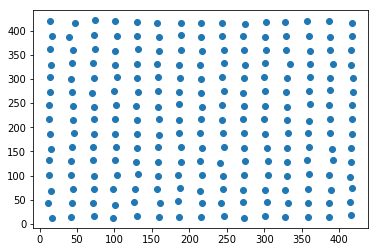

In [164]:
# leaflet 1
# divide the leaflet into a grid and calculate the concentration ratio in each box

bary1 = []
#del Mphi1
Mphi1_Lo = np.zeros((N,N))

for i in range(0,N):
    xs = xmin + i*dx
    for j in range(0,N):
        ys = ymin + j*dy
        
        # barycenter of all molecules in each box
        sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
        b1=leaflet1.select_atoms(sel).centroid().tolist()
        bary1.append(b1)
        
        # composition rates in each box
        sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
        tot1PC= leaflet1.select_atoms(sel_totPC).positions
        n_tot1PC=len(tot1PC) # total number of PC
        
        sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
        Lo1= leaflet1.select_atoms(sel_Lo).positions
        n_Lo1=len(Lo1) # number of molecules of the Lo phase (DPPC here)
        
        sel_Ld= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DIPC"
        Ld1= leaflet1.select_atoms(sel_Ld).positions
        n_Ld1=len(Ld1) # number of molecules of the Ld phase (DIPC here)
        
        sel_GM1= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and name GM1"
        GM1_1= leaflet1.select_atoms(sel_GM1).positions
        n_GM1_1=len(GM1_1) # number of GM1 molecules
        
        
        if  n_tot1PC!=0:
            phi1_Lo=n_Lo1/n_tot1PC
        else :
            print('leaflet 1, empty box: i=%d and j=%d' % (i,j))
        
        Mphi1_Lo[i,j]=phi1_Lo
        
bary1=np.array(bary1)

plt.scatter(bary1[:,0],bary1[:,1])

print(np.shape(bary1))

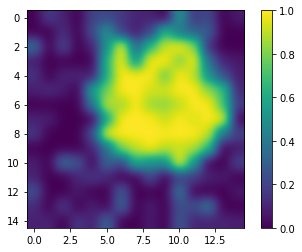

In [165]:
# DPPC / (DPPC+DIPC) leaflet 0
plt.imshow(Mphi0_Lo, interpolation='gaussian')
plt.colorbar()

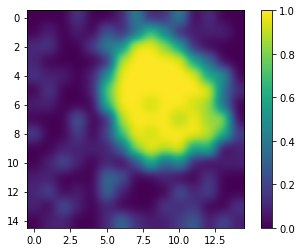

In [166]:
# DPPC / (DPPC+DIPC) leaflet 1
plt.imshow(Mphi1_Lo, interpolation='gaussian')
plt.colorbar()

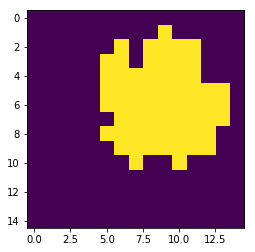

In [167]:
# upper leaflet binary composition

threshold = 0.6 # composition threshold from which the box is considered Lo, below it is considered Ld

Mphi0_bin = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        if Mphi0_Lo[i,j]>= threshold :
            Mphi0_bin[i,j]=1


#print(Mphi0_bin)          

plt.imshow(Mphi0_bin)

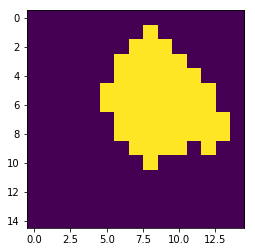

In [168]:
# lower leaflet binary composition

threshold = 0.6 # composition threshold from which the box is considered Lo, below it is considered Ld

Mphi1_bin = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        if Mphi1_Lo[i,j]>= threshold :
            Mphi1_bin[i,j]=1


#print(Mphi1_bin)          

plt.imshow(Mphi1_bin)

In [169]:
print(Mphi1_bin)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [170]:
# for Mphi1_bin

nb_Lo = int(np.sum(Mphi1_bin))
print(nb_Lo)

coords_Lo = np.zeros((nb_Lo,2))
l = 0

for i in range(N):
    for j in range(N):
        if Mphi1_bin[i,j]==1 :
            coords_Lo[l][0]=i
            coords_Lo[l][1]=j
            l += 1
#print(coords_Lo)
box_x_mean = np.mean(coords_Lo[:,0])
box_y_mean = np.mean(coords_Lo[:,1])
print(box_x_mean)
print(box_y_mean)

box_x_max = 0
box_y_max = 0

for i in range(N):
    for j in range(N):
        if Mphi1_bin[i,j]==1 and np.abs(i-box_x_mean) > box_x_max:
            box_x_max = np.abs(i-box_x_mean)
        if Mphi1_bin[i,j]==1 and np.abs(j-box_y_mean) > box_y_max:
            box_y_max = np.abs(j-box_y_mean)
print(box_x_max)
print(box_y_max)
box_max = np.ceil(max(box_x_max,box_y_max))
print(box_max)

53
5.830188679245283
8.773584905660377
4.830188679245283
4.2264150943396235
5.0


(4.590143369175627,
 13.409856630824374,
 -10.465176600441502,
 -0.5348233995584987)

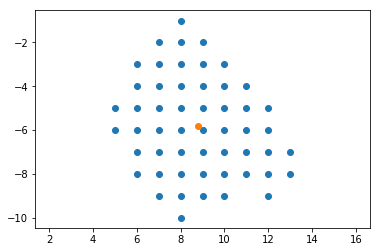

In [171]:
plt.scatter(coords_Lo[:,1], -coords_Lo[:,0])
plt.scatter(box_y_mean, -box_x_mean)
plt.axis('equal')

In [217]:
x_mean = box_x_mean /N * (xmax-xmin)
y_mean = box_y_mean /N * (ymax-ymin)
r_max = box_max /N * (ymax-ymin) *1.2
print(x_mean)
print(y_mean)
print(r_max)

167.60627648695458
252.24643865621314
172.5040161132812


In [218]:
nb_r = 8
dr = int(r_max/nb_r)

nb_theta = 12
dtheta = 2*np.pi/nb_theta

In [219]:
# leaflet 1
# divide the leaflet into a pie  and calculate the concentration ratio in each box

sel_tot = "all and (name PO4)"
M = leaflet1.select_atoms(sel_tot).positions
x = M[:,0]
y = M[:,1]

x_pie_r = [[] for r in range(nb_r)]
y_pie_r = [[] for r in range(nb_r)]
pie_r = [[] for r in range(nb_r)]

x_pie_theta = [[] for t in range(nb_theta)]
y_pie_theta = [[] for t in range(nb_theta)]
pie_theta = [[] for t in range(nb_theta)]


r_crown = 0
for r in range(nb_r):

    x_r = []
    y_r = []
    i_r = []
    
    r_crown = r_crown+dr
    
    for i in range(len(M)):
        xi = M[i,0]
        yi = M[i,1]

        if (xi-x_mean)**2+(yi-y_mean)**2 < r_crown**2 and (xi-x_mean)**2+(yi-y_mean)**2 >= (r_crown-dr)**2:
            x_r.append(xi)
            y_r.append(yi)
            i_r.append(i)
        
    x_pie_r[r] = x_r
    y_pie_r[r] = y_r
    pie_r[r] = i_r
    
for i in range(len(M)):
    xi = M[i,0]
    yi = M[i,1]
    
    theta = np.arccos((xi-x_mean)/np.sqrt((xi-x_mean)**2+(yi-y_mean)**2))
    t = int(np.floor(theta/dtheta))
    if yi<y_mean : # if angle > pi
        t = nb_theta-t-1
    
    x_pie_theta[t].append(xi)
    y_pie_theta[t].append(yi)
    pie_theta[t].append(i)

(-24.235530834258448,
 453.0539747197528,
 -27.547945052182857,
 453.2062889467297)

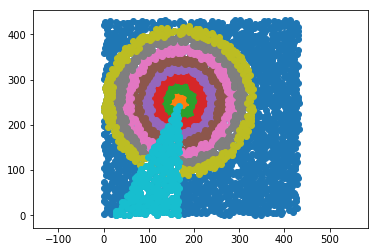

In [220]:
plt.scatter(x,y)

for r in range(nb_r):
    plt.scatter(x_pie_r[r], y_pie_r[r])
    
#for t in range():
    #plt.scatter(x_pie_theta[t], y_pie_theta[t])
t=8;    
plt.scatter(x_pie_theta[t], y_pie_theta[t])    
plt.axis('equal')

In [221]:
# leaflet 1
# divide the leaflet into a pie  and calculate the concentration ratio in each box

sel_tot = "all and (name PO4 and resname DPPC)"
M = leaflet1.select_atoms(sel_tot).positions

x_pie_r_Lo = [[] for r in range(nb_r)]
y_pie_r_Lo = [[] for r in range(nb_r)]
pie_r_Lo = [[] for r in range(nb_r)]

x_pie_theta_Lo = [[] for t in range(nb_theta)]
y_pie_theta_Lo = [[] for t in range(nb_theta)]
pie_theta_Lo = [[] for t in range(nb_theta)]


r_crown = 0
for r in range(nb_r):

    x_r = []
    y_r = []
    i_r = []
    
    r_crown = r_crown+dr
    
    for i in range(len(M)):
        xi = M[i,0]
        yi = M[i,1]

        if (xi-x_mean)**2+(yi-y_mean)**2 < r_crown**2 and (xi-x_mean)**2+(yi-y_mean)**2 >= (r_crown-dr)**2:
            x_r.append(xi)
            y_r.append(yi)
            i_r.append(i)
        
    x_pie_r_Lo[r] = x_r
    y_pie_r_Lo[r] = y_r
    pie_r_Lo[r] = i_r
    
for i in range(len(M)):
    xi = M[i,0]
    yi = M[i,1]
    
    theta = np.arccos((xi-x_mean)/np.sqrt((xi-x_mean)**2+(yi-y_mean)**2))
    t = int(np.floor(theta/dtheta))
    if yi<y_mean : # if angle > pi
        t = nb_theta-t-1
    
    x_pie_theta_Lo[t].append(xi)
    y_pie_theta_Lo[t].append(yi)
    pie_theta_Lo[t].append(i)

(-21.440858466885853,
 452.92089508321124,
 -21.498177937269375,
 452.9182047984005)

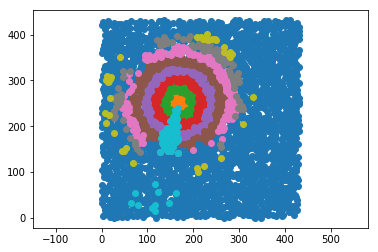

In [222]:
plt.scatter(x,y)

for r in range(nb_r):
    plt.scatter(x_pie_r_Lo[r], y_pie_r_Lo[r])
    
#for t in range():
    #plt.scatter(x_pie_theta[t], y_pie_theta[t])
t=8;    
plt.scatter(x_pie_theta_Lo[t], y_pie_theta_Lo[t])    
plt.axis('equal')

In [223]:
pie = [[[] for t in range(nb_theta)] for r in range(nb_r)]

In [224]:
for r in range(nb_r):
        for t in range(nb_theta):
            for l in range(len(pie_r[r])):
                if (pie_r[r][l] in pie_theta[t]):
                    pie[r][t].append(pie_r[r][l])
    

In [225]:
for r in range(nb_r):
    for t in range(nb_theta):
        print('r=%d t=%d %d' % (r,t,len(pie[r][t])) )

r=0 t=0 1
r=0 t=1 3
r=0 t=2 1
r=0 t=3 1
r=0 t=4 2
r=0 t=5 2
r=0 t=6 1
r=0 t=7 1
r=0 t=8 2
r=0 t=9 2
r=0 t=10 1
r=0 t=11 3
r=1 t=0 6
r=1 t=1 7
r=1 t=2 6
r=1 t=3 6
r=1 t=4 7
r=1 t=5 5
r=1 t=6 5
r=1 t=7 7
r=1 t=8 6
r=1 t=9 5
r=1 t=10 6
r=1 t=11 4
r=2 t=0 9
r=2 t=1 12
r=2 t=2 10
r=2 t=3 10
r=2 t=4 7
r=2 t=5 11
r=2 t=6 11
r=2 t=7 11
r=2 t=8 8
r=2 t=9 9
r=2 t=10 10
r=2 t=11 10
r=3 t=0 14
r=3 t=1 12
r=3 t=2 12
r=3 t=3 12
r=3 t=4 15
r=3 t=5 14
r=3 t=6 13
r=3 t=7 13
r=3 t=8 13
r=3 t=9 11
r=3 t=10 13
r=3 t=11 13
r=4 t=0 15
r=4 t=1 15
r=4 t=2 16
r=4 t=3 18
r=4 t=4 19
r=4 t=5 15
r=4 t=6 17
r=4 t=7 19
r=4 t=8 14
r=4 t=9 14
r=4 t=10 15
r=4 t=11 17
r=5 t=0 16
r=5 t=1 21
r=5 t=2 18
r=5 t=3 26
r=5 t=4 16
r=5 t=5 19
r=5 t=6 21
r=5 t=7 21
r=5 t=8 18
r=5 t=9 19
r=5 t=10 20
r=5 t=11 19
r=6 t=0 28
r=6 t=1 20
r=6 t=2 21
r=6 t=3 20
r=6 t=4 21
r=6 t=5 26
r=6 t=6 21
r=6 t=7 23
r=6 t=8 24
r=6 t=9 18
r=6 t=10 19
r=6 t=11 21
r=7 t=0 19
r=7 t=1 26
r=7 t=2 26
r=7 t=3 21
r=7 t=4 27
r=7 t=5 27
r=7 t=6 24
r=7 t=7 26
r=

In [226]:
pie_Lo = [[[] for t in range(nb_theta)] for r in range(nb_r)]

In [227]:
for r in range(nb_r):
        for t in range(nb_theta):
            for l in range(len(pie_r_Lo[r])):
                if (pie_r_Lo[r][l] in pie_theta_Lo[t]):
                    pie_Lo[r][t].append(pie_r_Lo[r][l])
    

In [228]:
for r in range(nb_r):
    for t in range(nb_theta):
        print('r=%d t=%d %d' % (r,t,len(pie_Lo[r][t])) )

r=0 t=0 1
r=0 t=1 3
r=0 t=2 1
r=0 t=3 1
r=0 t=4 2
r=0 t=5 2
r=0 t=6 1
r=0 t=7 1
r=0 t=8 2
r=0 t=9 2
r=0 t=10 1
r=0 t=11 3
r=1 t=0 6
r=1 t=1 7
r=1 t=2 6
r=1 t=3 6
r=1 t=4 7
r=1 t=5 5
r=1 t=6 5
r=1 t=7 7
r=1 t=8 6
r=1 t=9 5
r=1 t=10 6
r=1 t=11 3
r=2 t=0 9
r=2 t=1 12
r=2 t=2 10
r=2 t=3 10
r=2 t=4 7
r=2 t=5 11
r=2 t=6 11
r=2 t=7 11
r=2 t=8 8
r=2 t=9 9
r=2 t=10 10
r=2 t=11 10
r=3 t=0 14
r=3 t=1 10
r=3 t=2 11
r=3 t=3 12
r=3 t=4 15
r=3 t=5 14
r=3 t=6 13
r=3 t=7 13
r=3 t=8 13
r=3 t=9 11
r=3 t=10 12
r=3 t=11 12
r=4 t=0 15
r=4 t=1 15
r=4 t=2 15
r=4 t=3 18
r=4 t=4 18
r=4 t=5 15
r=4 t=6 16
r=4 t=7 14
r=4 t=8 10
r=4 t=9 8
r=4 t=10 13
r=4 t=11 17
r=5 t=0 15
r=5 t=1 19
r=5 t=2 15
r=5 t=3 16
r=5 t=4 7
r=5 t=5 6
r=5 t=6 16
r=5 t=7 11
r=5 t=8 5
r=5 t=9 1
r=5 t=10 6
r=5 t=11 17
r=6 t=0 12
r=6 t=1 17
r=6 t=2 14
r=6 t=3 9
r=6 t=4 1
r=6 t=5 9
r=6 t=6 7
r=6 t=7 5
r=6 t=8 0
r=6 t=9 0
r=6 t=10 2
r=6 t=11 5
r=7 t=0 1
r=7 t=1 7
r=7 t=2 8
r=7 t=3 0
r=7 t=4 1
r=7 t=5 6
r=7 t=6 4
r=7 t=7 4
r=7 t=8 0
r=7 t=9 3
r=7 t

In [229]:
threshold = 0.6
M_pie_bin = np.zeros((nb_r, nb_theta))

for r in range(nb_r):
    for t in range(nb_theta):
        if(len(pie_Lo[r][t])/len(pie[r][t])>=threshold):
            M_pie_bin[r,t]=1

In [230]:
print(M_pie_bin)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [231]:
boundary = [[],[]]

for t in range(nb_theta):
    
    boundary[0].append(t)
    
    for r in range(1,nb_r-2,1):
        b_found = 0
        if M_pie_bin[r,t]==1 and (M_pie_bin[r+1,t]==0 or r+1>=nb_r) and (M_pie_bin[r+2,t]==0 or r+2>=nb_r):
            b_found = 1
            boundary[1].append(r)
    if b_found == 0:
        if M_pie_bin[nb_r-2,t]==1 and M_pie_bin[nb_r-1,t]!=1:
            boundary[1].append(nb_r-2)
        elif M_pie_bin[nb_r-1,t]==1:
            boundary[1].append(nb_r-1)
                
theta_l = np.array(boundary[0])
r_theta = np.array(boundary[1])
print(theta_l)
print(r_theta)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[5 6 6 5 4 4 5 4 4 3 4 5]


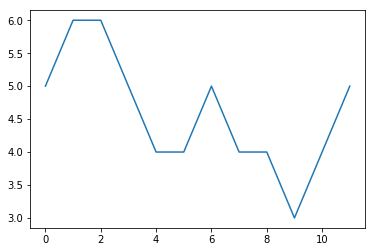

In [232]:
plt.plot(theta_l,r_theta)

In [233]:
r_q = np.fft.rfft(r_theta)
for i in range((len(r_q))):
    print(r_q[i])

(55+0j)
(3.598076211353314-4.232050807568879j)
(2.5000000000000018-2.598076211353316j)
(-2+1j)
(-0.4999999999999989+0.8660254037844395j)
(-1.5980762113533165-0.7679491924311241j)
(1+0j)


In [234]:
r_q_pow = abs(r_q)**2
print(r_q_pow)

[3.02500000e+03 3.08564065e+01 1.30000000e+01 5.00000000e+00
 1.00000000e+00 3.14359354e+00 1.00000000e+00]


[0. 1. 2. 3. 4. 5. 6.]


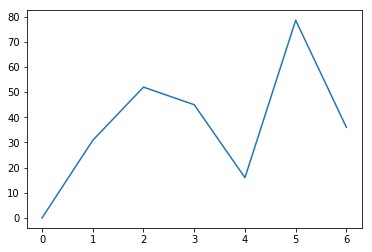

In [235]:
q = np.arange(nb_theta/2+1)
print(q)
plt.plot(r_q_pow*q**2)